# 캐글 경진대회 : 집값 예측

### [ 주요 내용 ]

#### (1) 캐글제공 Base-line 모델 테스트
 1. 자료 전처리: 결측치 점검, 수치 편향성 조사 --> 로그 정규화
 1. Ensemble 기법 적용 : gboost, xgboost, lightgbm 모델 예측치 평균 적용
    
#### (2) Exploration Node 주요내용 테스트   
 1. 하이퍼 파라미터 튜닝 : lightgbm 모델 (max_dept = 10, n_estimator = 100 으로 튜닝)  
 1. 주요 수행내용 함수화: cross-validation, tuning, reporting 등
    
#### (3) 추가 분석 및 테스트    
 1. 데이터 분석 추가 : 상관관계 분석 (가격과 상관성 높은 변수 분석), 이상치 제거  
 1. Ensemble 기법 모델 추가 : 4개 모델 (boost, xgboost, lightgbm, RandomForest) 예측치 평균 적용  
 1. 하이퍼 파라미터 추가 튜닝 : 
    - lightgbm 모델 (max_dept = 10, n_estimator = 100 으로 튜닝)  
    - XGBRegressor 모델 (learning_rate = 0.1, max_depth = 8 으로 튜닝)
        
#### 캐글 리더보드의 Private score : 112,735

### 1. 데이터 파일 Load & Explorer(전처리)

In [1]:
# 필요 라이브러리 import & 환경설정
import warnings
warnings.filterwarnings("ignore")
import os
from os.path import join
import numpy as np
import pandas as pd
import missingno as msno
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import KFold,cross_val_score
import xgboost as xgb
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [35]:
# 파일경로 설정
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
train_data_path = join(data_dir, 'train.csv')
sub_data_path = join(data_dir, 'test.csv')
print(train_data_path)
print(sub_data_path)

/aiffel/aiffel/kaggle_kakr_housing/data/train.csv
/aiffel/aiffel/kaggle_kakr_housing/data/test.csv


In [36]:
data = pd.read_csv(train_data_path)
sub = pd.read_csv(sub_data_path)
print('train data dim: {}'.format(data.shape))
print('sub data dim: {}'.format(sub.shape))

train data dim: (15035, 21)
sub data dim: (6468, 20)


In [38]:
# price 컬럼 y 변수 저장 및 해당 컬럼 삭제
y = data['price']
del data['price']
print(data.columns)

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [39]:
# 학습데이터와 테스트 데이터 합치기
train_len = len(data)
data = pd.concat((data,sub), axis=0)
print(len(data))

21503


In [40]:
data.head()

,id,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


<AxesSubplot:>

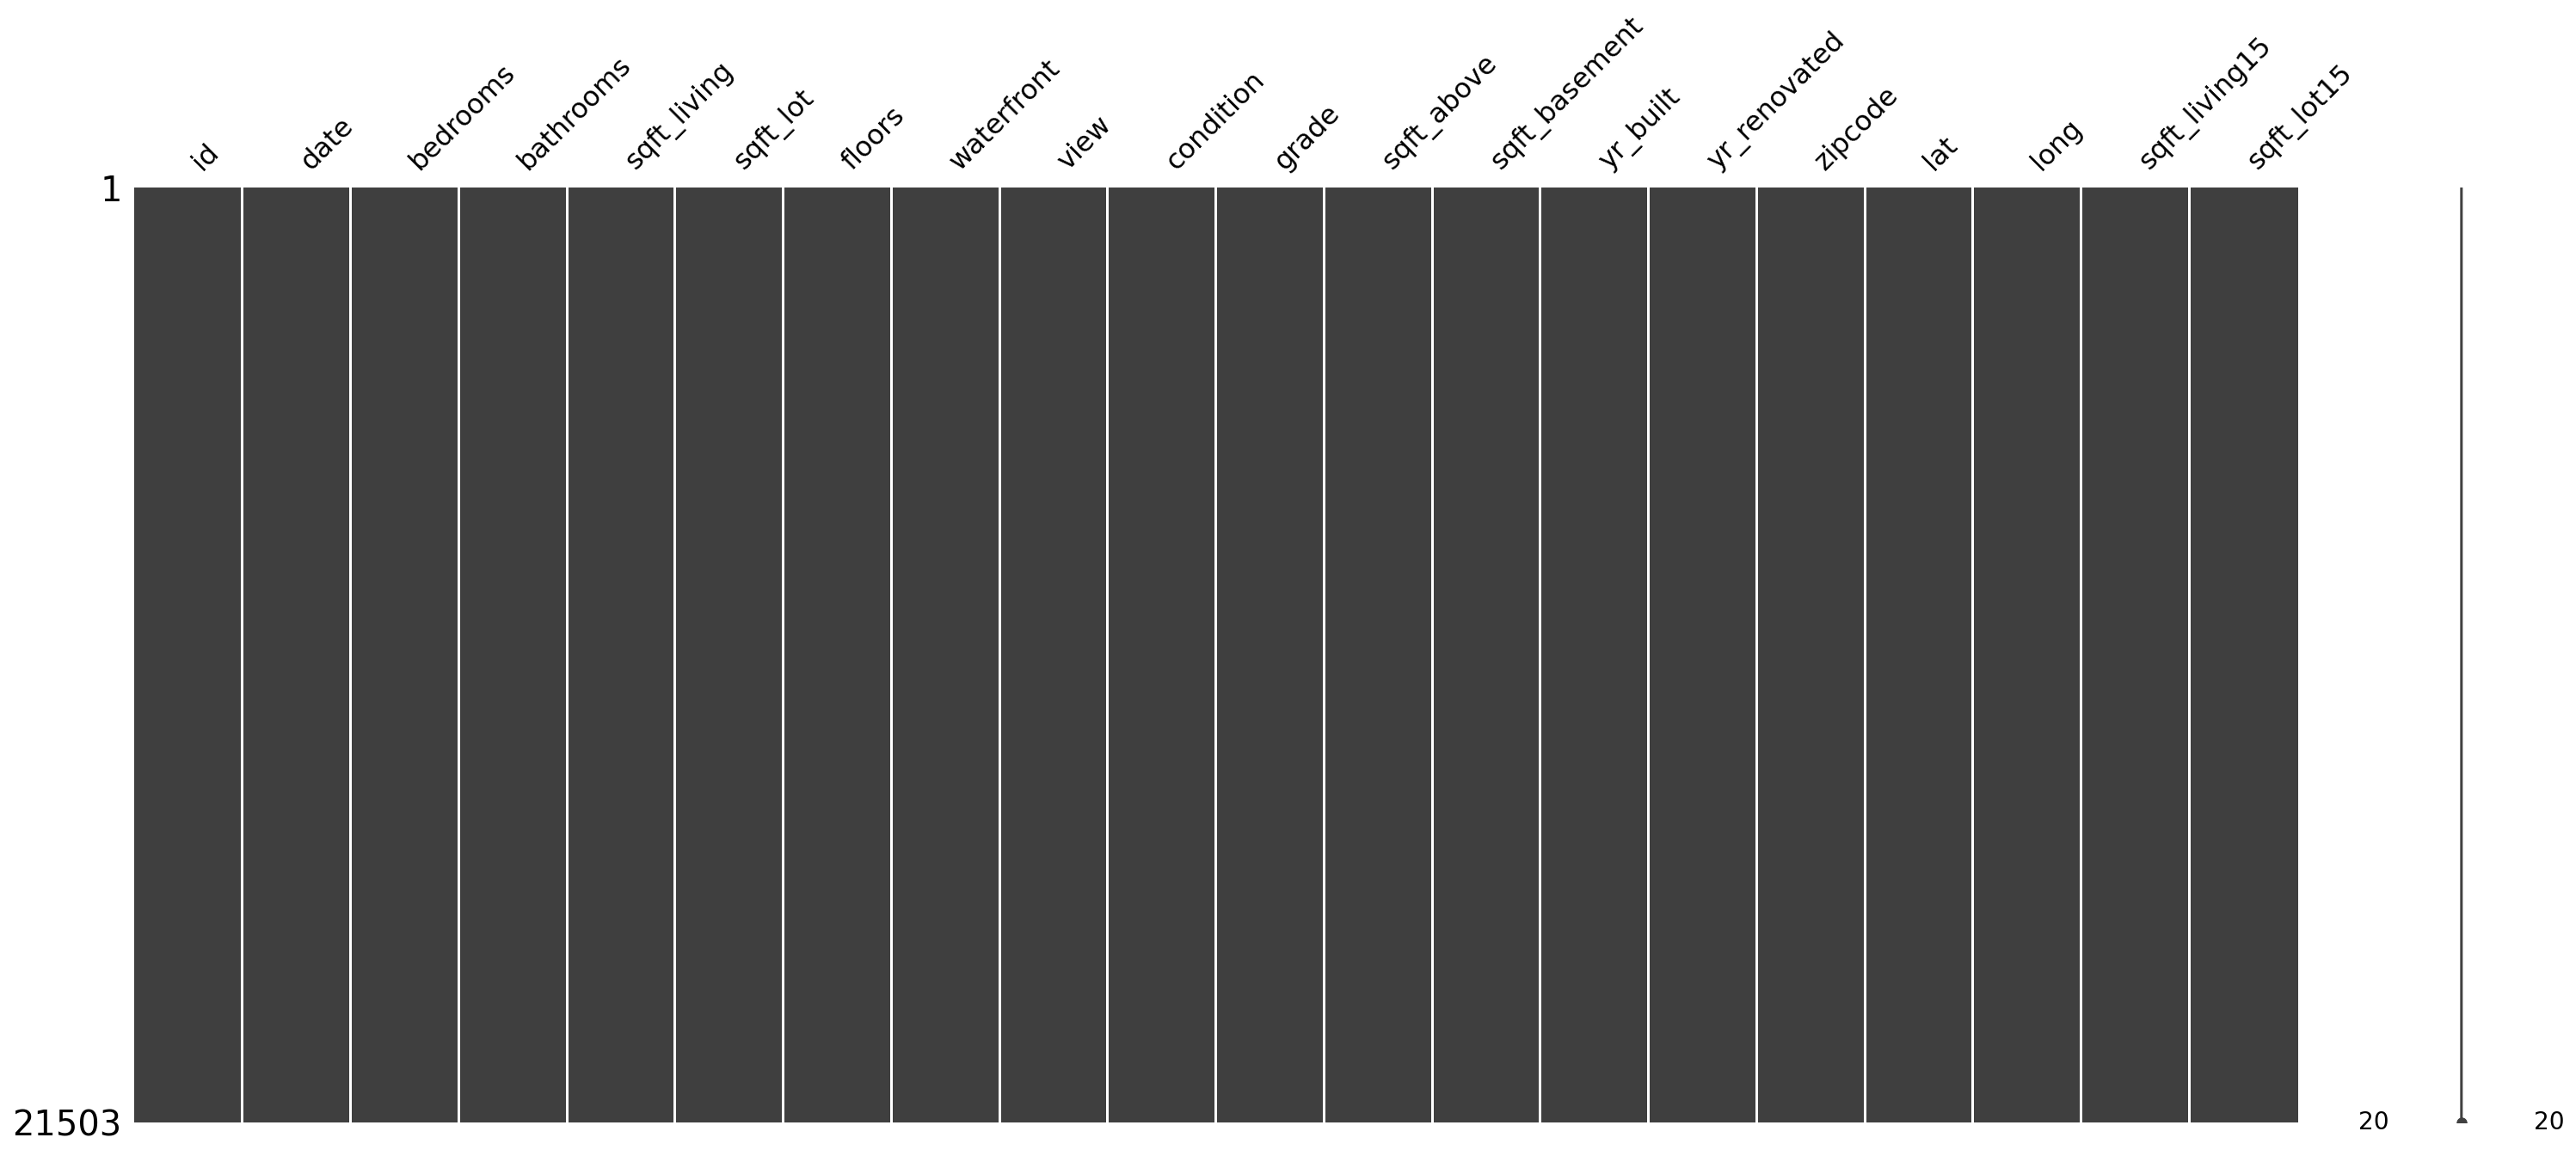

In [8]:
# 결측치 확인
msno.matrix(data)

In [9]:
# 결측치 개별 확인
null_check = pd.isnull(data['id'])
print(null_check)

0       False
1       False
2       False
3       False
4       False
        ...  
6463    False
6464    False
6465    False
6466    False
6467    False
Name: id, Length: 21503, dtype: bool


In [10]:
null_data = data.loc[null_check,'id']
null_data.head()

Series([], Name: id, dtype: int64)

In [11]:
# 결측치 데이터의 개수를 카운터
print('{}: {}'.format('id', len(null_data.values)))

id: 0


In [12]:
for c in data.columns:
    print('{}: {}'.format(c, len(data.loc[pd.isnull(data[c]),c].values)))

id: 0
date: 0
bedrooms: 0
bathrooms: 0
sqft_living: 0
sqft_lot: 0
floors: 0
waterfront: 0
view: 0
condition: 0
grade: 0
sqft_above: 0
sqft_basement: 0
yr_built: 0
yr_renovated: 0
zipcode: 0
lat: 0
long: 0
sqft_living15: 0
sqft_lot15: 0


In [41]:
# id제거
sub_id = data['id'][train_len:]
del data['id']
print(data.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15'],
      dtype='object')


In [14]:
# date 변수 정리
data['date'] = data['date'].apply(lambda x:str(x[:6]))
data.head()

,date,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,201410,3,1.00,1180,5650,1.0,0,0,3,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,201502,2,1.00,770,10000,1.0,0,0,3,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,201502,3,2.00,1680,8080,1.0,0,0,3,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,201406,3,2.25,1715,6819,2.0,0,0,3,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,201501,3,1.50,1060,9711,1.0,0,0,3,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


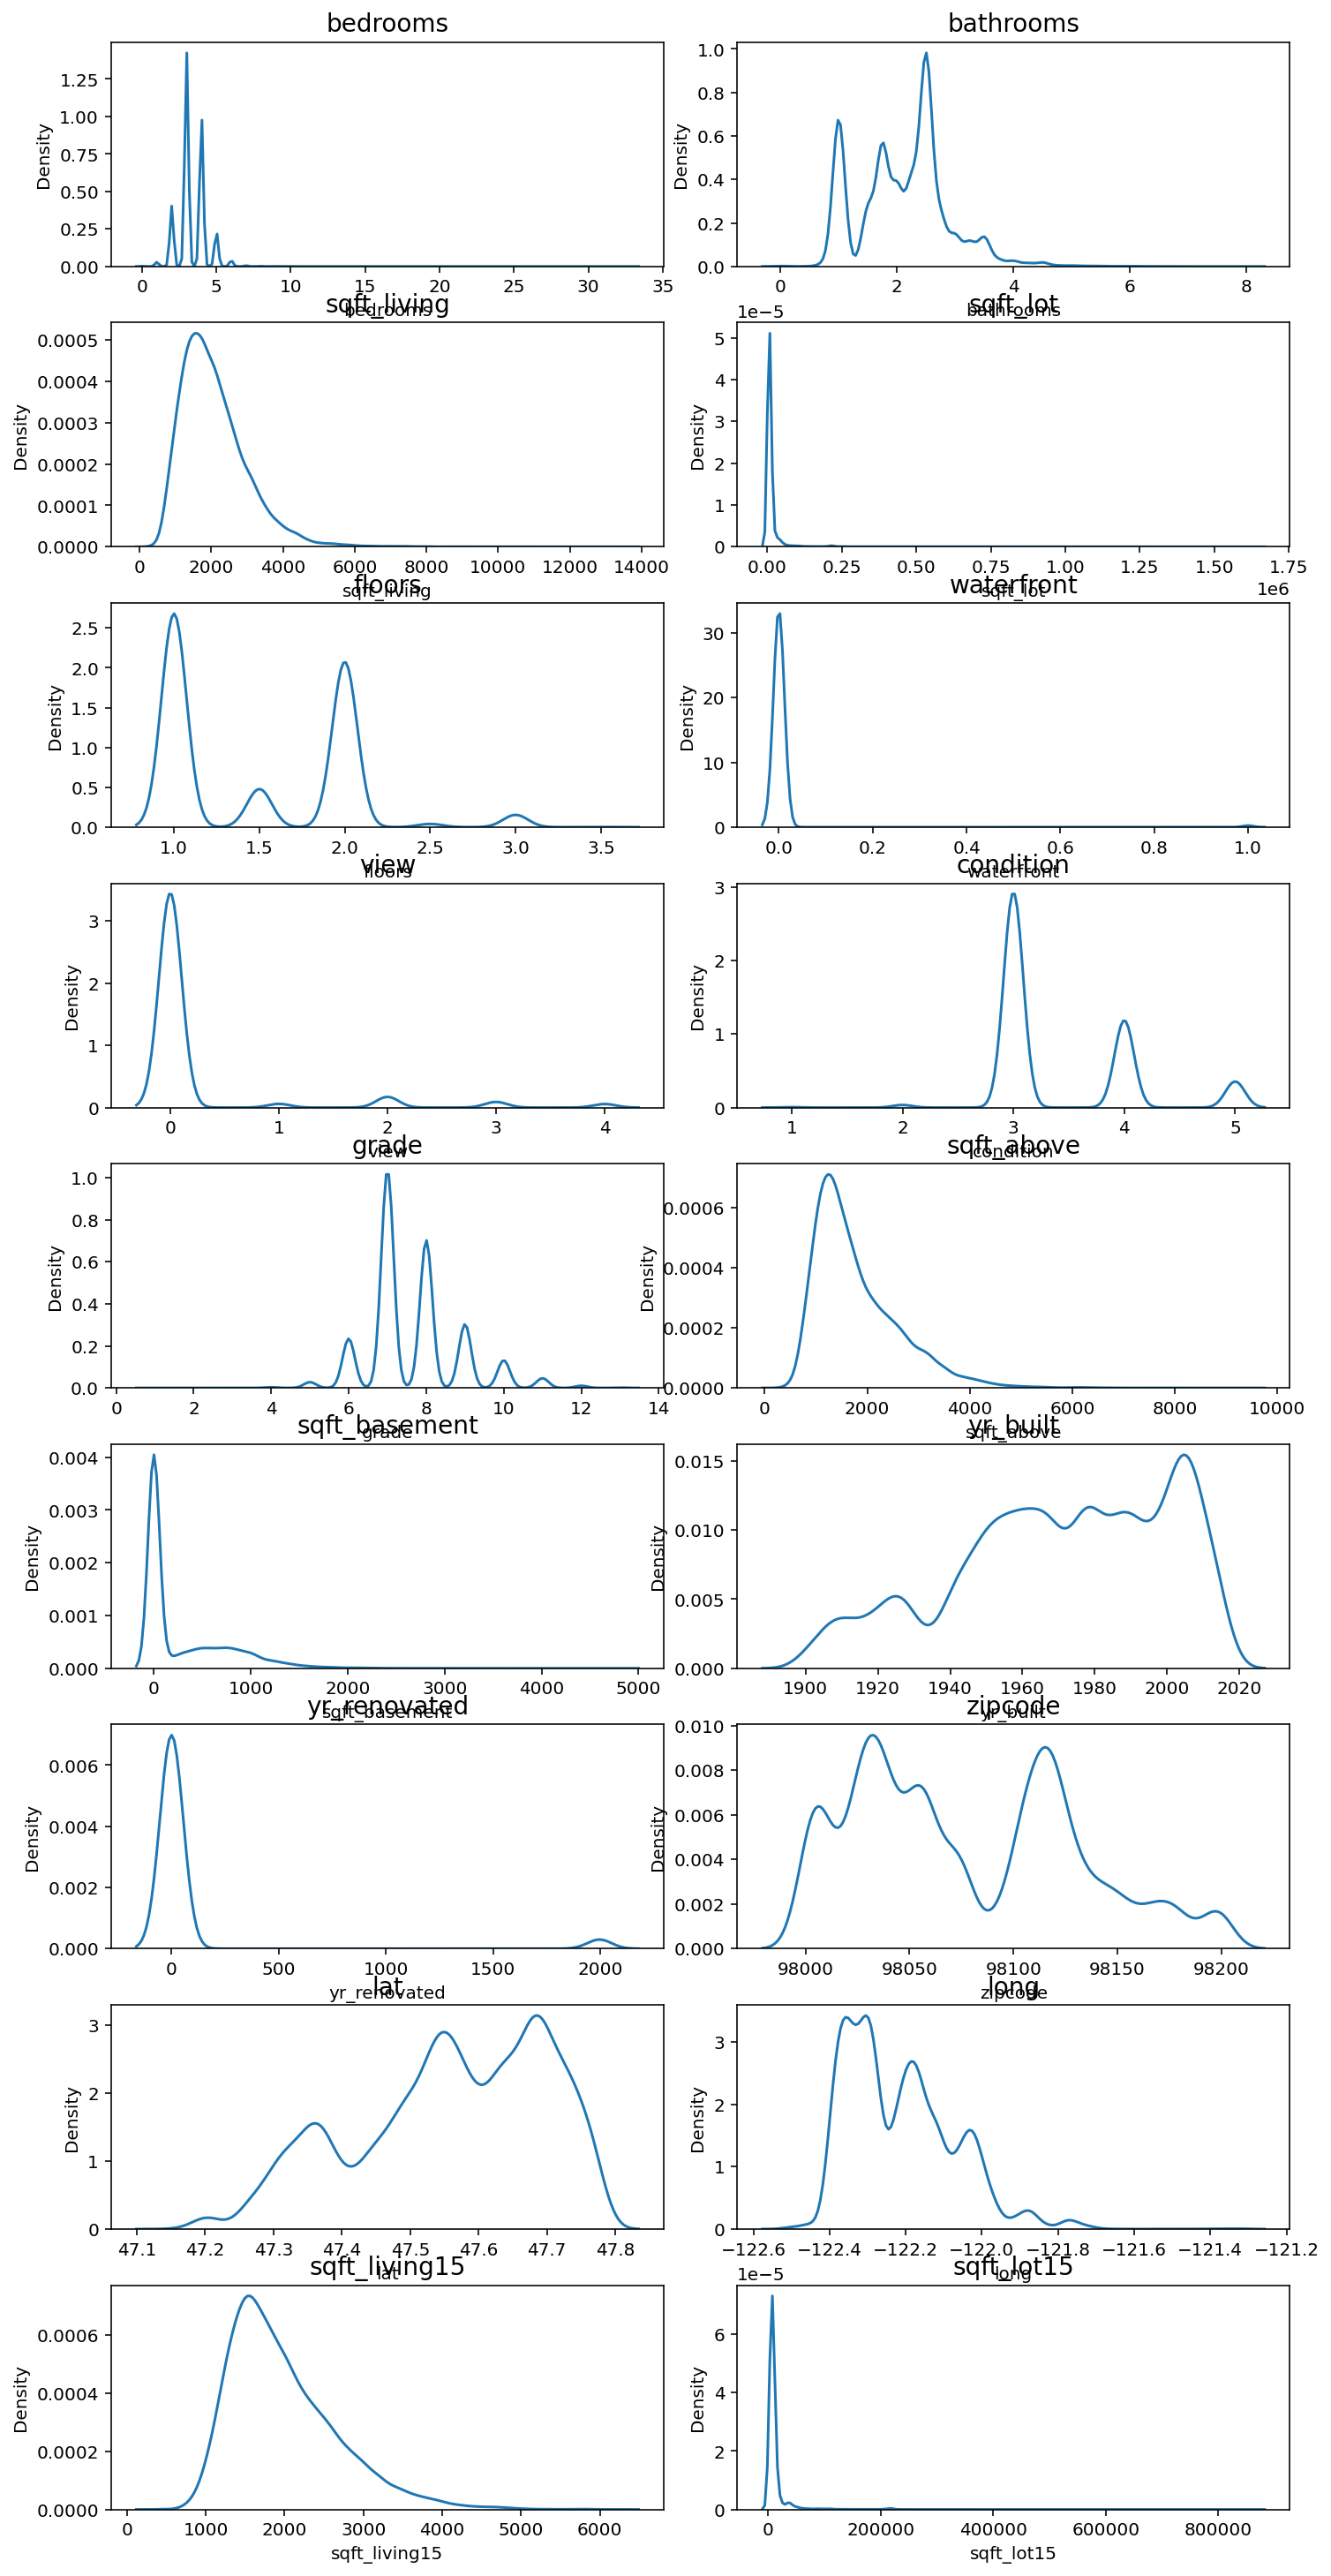

In [15]:
# 각 변수들 분포 확인
fig, ax = plt.subplots(9,2,figsize=(10,20))
fig.tight_layout()
# id 변수(count=0)는 제외하고 분포 확인
count = 1
columns = data.columns
for row in range(9):
    for col in range(2):
        sns.kdeplot(data=data[columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count],fontsize=14)
        count += 1
        if count == 19:
            break

In [17]:
# skew 변수에 대해 로그변환
skew_columns = ['bedrooms', 'sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement', 'sqft_lot15','sqft_living15']
for c in skew_columns:
    data[c] = np.log1p(data[c].values)    

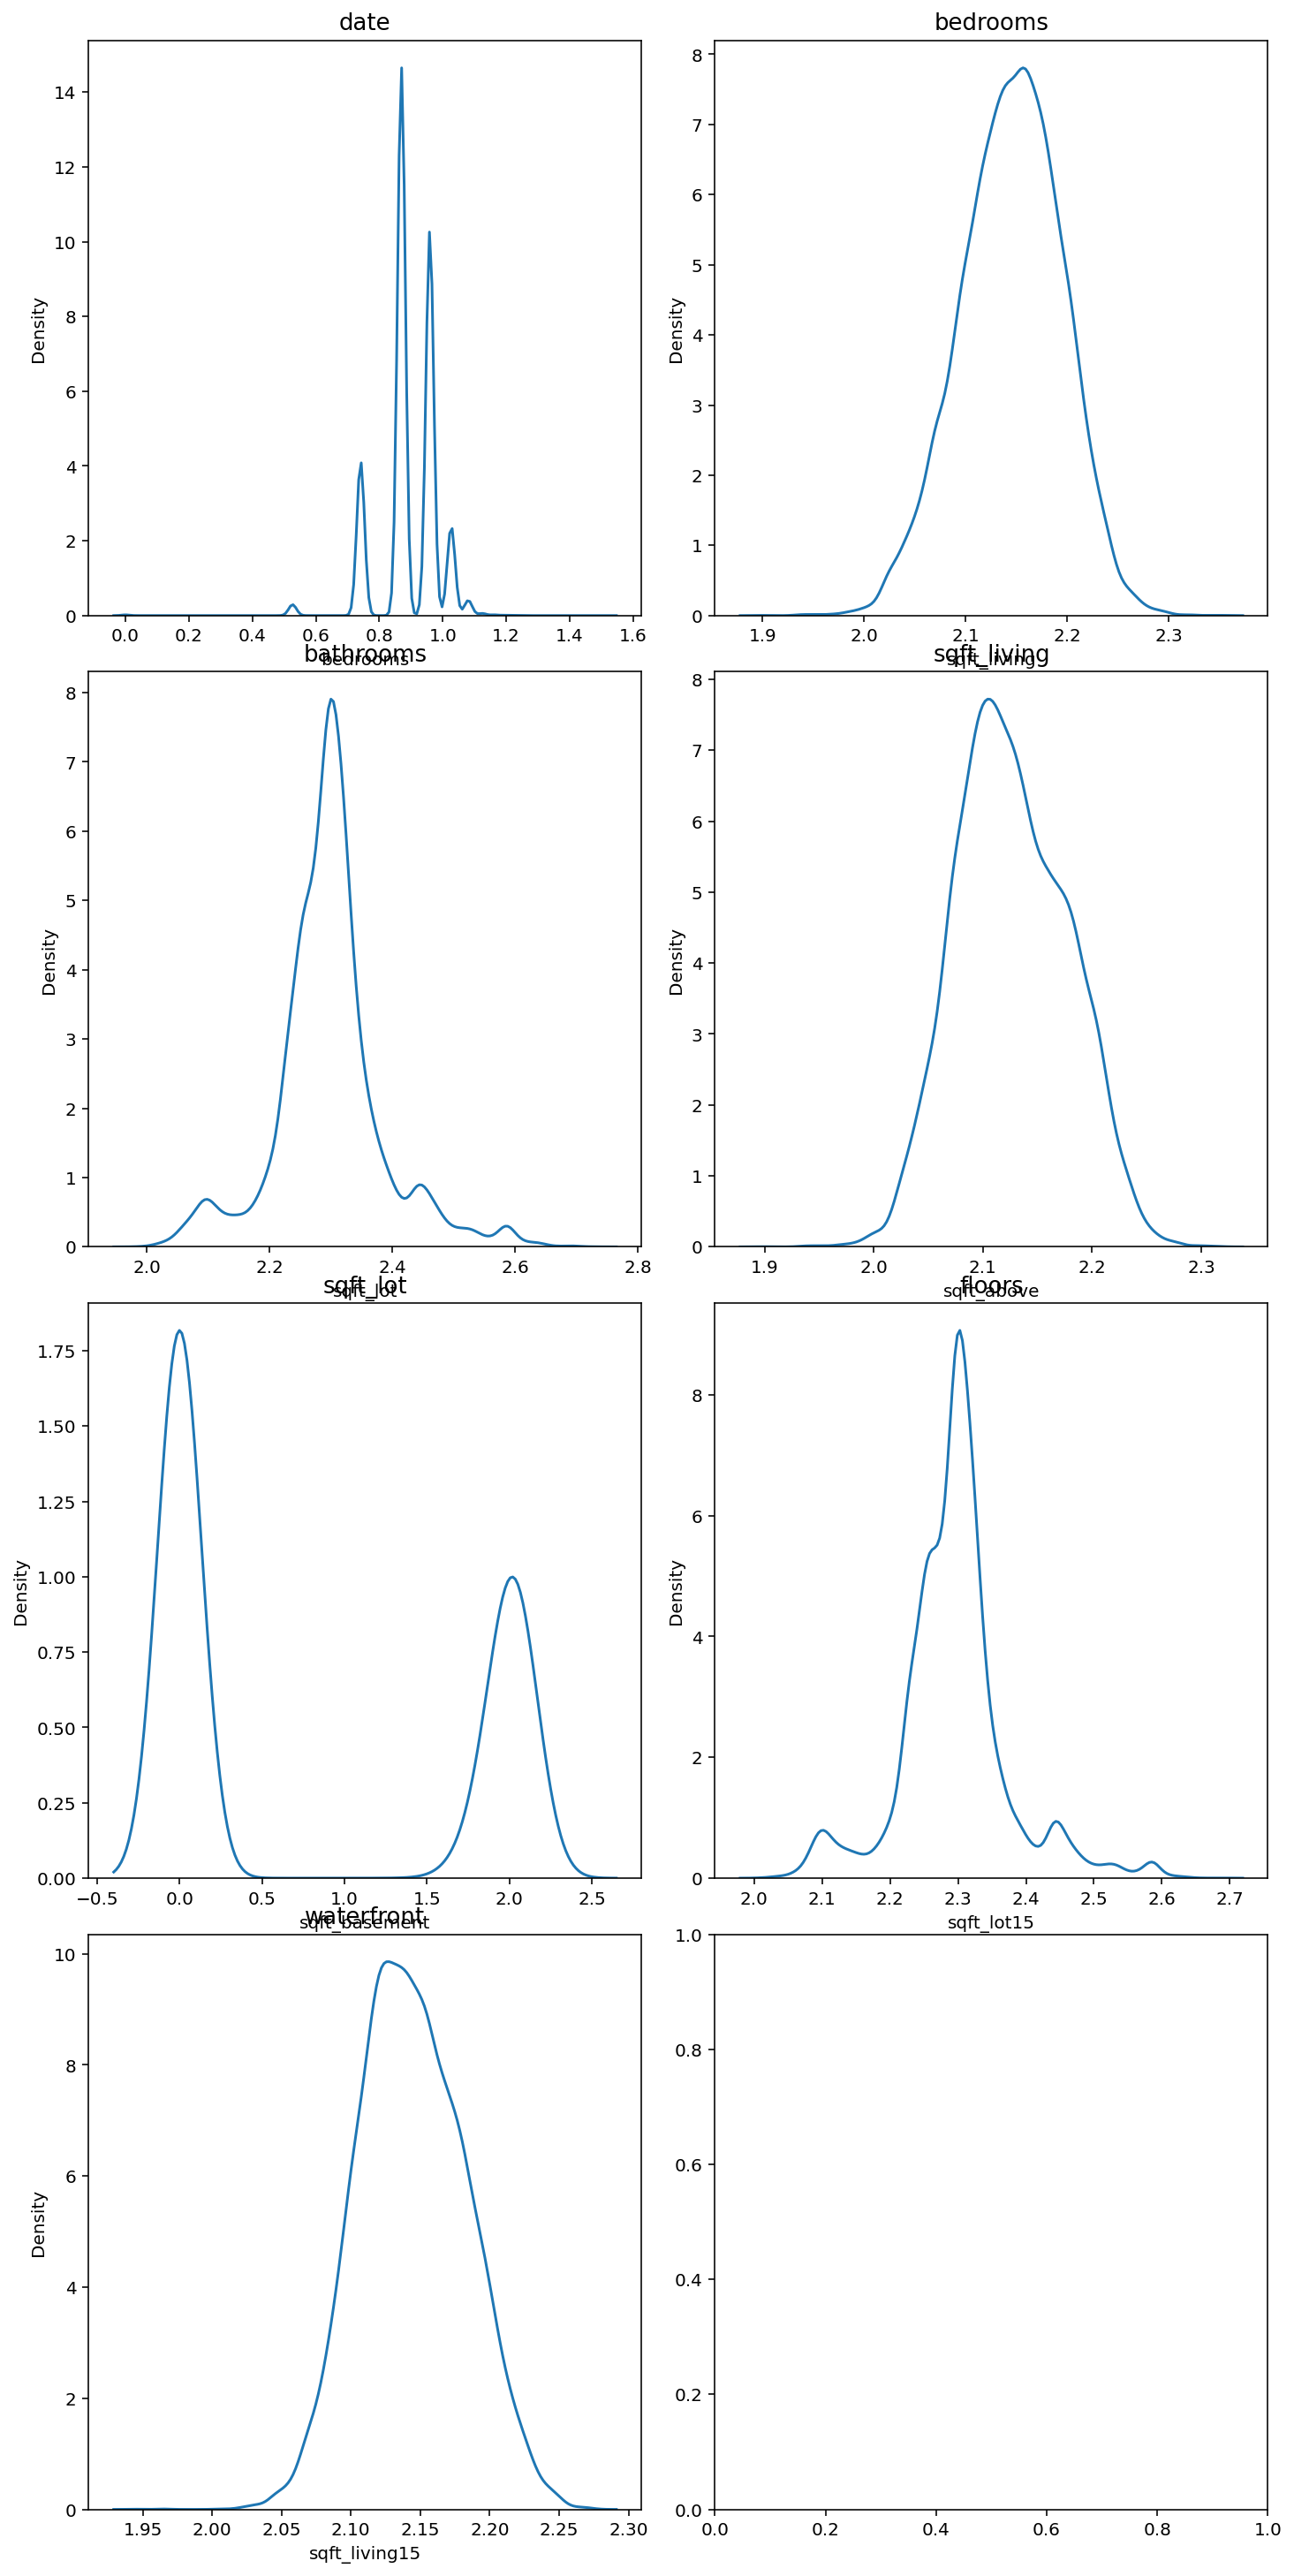

In [18]:
# 각 변수들 분포 확인
fig, ax = plt.subplots(4,2,figsize=(10,20))
fig.tight_layout()
count = 0
for row in range(4):
    for col in range(2):
        if count == 7:
            break
        sns.kdeplot(data=data[skew_columns[count]], ax=ax[row][col])
        ax[row][col].set_title(columns[count],fontsize=13)
        count += 1
        

In [19]:
# 데이터 분리
sub =data.iloc[train_len:, :]
x = data.iloc[:train_len,:]
print(x.shape)
print(sub.shape)

(15035, 19)
(6468, 19)


### 2. 모델링 & Ensemble & Prediction

In [20]:
# Ensemble 기법 사용 : 여러 회귀모델의 평균 블렌딩 모델
gboost = GradientBoostingRegressor(random_state=2020)
xgboost = xgb.XGBRegressor(random_state=2020)
lightgbm = lgb.LGBMRegressor(random_state=2020)
models = [{'model':gboost, 'name':'GradientBoosting'},{'model':xgboost,'name':'XGBoost'},{'model':lightgbm,'name':'LightGBM'}]


In [21]:
# Cross Validation : R2 점수 반환
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(x.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=x.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score: {CV_score:.4f}")
 
get_cv_score(models)

Model: GradientBoosting, CV score: 0.8609
Model: XGBoost, CV score: 0.8860
Model: LightGBM, CV score: 0.8819


In [22]:
# 각 모델들의 평균값 산출
def AveragingBlending(models, x, y,sub_x):
    for m in models:
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models,x,y,sub)
print(len(y_pred))
y_pred

6468


array([ 529966.66304912,  430726.21272617, 1361676.91242777, ...,
        452081.69137012,  341572.97685942,  421725.1231835 ])

### 3.모델의 개선 : 하이퍼 파라메터 튜닝

In [2]:
# 데이터 재구성
# data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
data_dir = os.getcwd() + '/data'
train_data_path = join(data_dir, 'train.csv')
test_data_path = join(data_dir, 'test.csv')
train = pd.read_csv(train_data_path)
test = pd.read_csv(test_data_path)

train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,20141013T000000,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,20150225T000000,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,20150218T000000,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,20140627T000000,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,20150115T000000,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


In [3]:
# date 정수형으로 변화: regression에 추가 활용
train['date'] = train['date'].apply(lambda i:i[:6]).astype(int)
train.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,0,201410,221900.0,3,1.00,1180,5650,1.0,0,0,...,7,1180,0,1955,0,98178,47.5112,-122.257,1340,5650
1,1,201502,180000.0,2,1.00,770,10000,1.0,0,0,...,6,770,0,1933,0,98028,47.7379,-122.233,2720,8062
2,2,201502,510000.0,3,2.00,1680,8080,1.0,0,0,...,8,1680,0,1987,0,98074,47.6168,-122.045,1800,7503
3,3,201406,257500.0,3,2.25,1715,6819,2.0,0,0,...,7,1715,0,1995,0,98003,47.3097,-122.327,2238,6819
4,4,201501,291850.0,3,1.50,1060,9711,1.0,0,0,...,7,1060,0,1963,0,98198,47.4095,-122.315,1650,9711


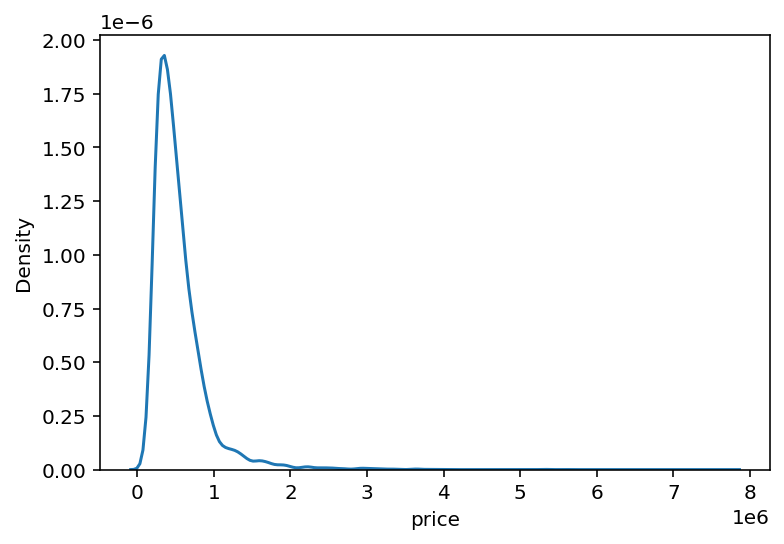

In [4]:
# price 분포 확인
sns.kdeplot(train['price'])
plt.show()

In [5]:
# 좌측 skew --> 로그변환
train['price'] = np.log1p(train['price'])
train['price']

0        12.309987
1        12.100718
2        13.142168
3        12.458779
4        12.583999
           ...    
15030    13.322338
15031    13.822984
15032    12.793862
15033    12.899222
15034    12.691584
Name: price, Length: 15035, dtype: float64

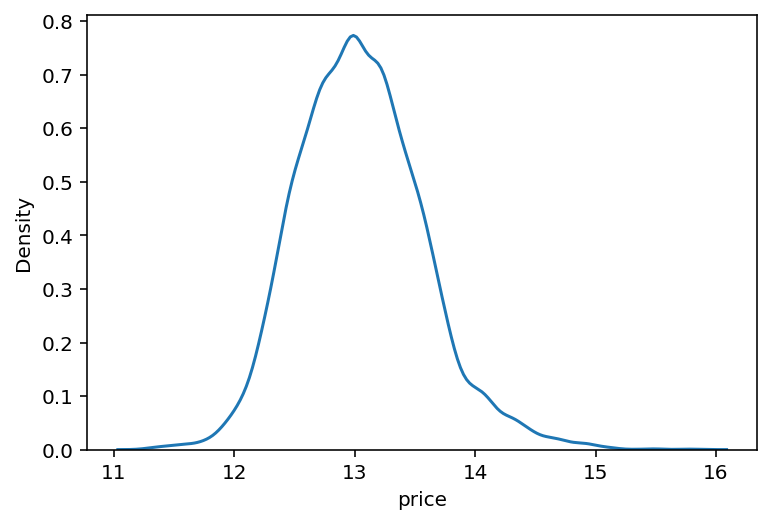

In [6]:
sns.kdeplot(train['price'])
plt.show()

['price' 'grade' 'sqft_living' 'sqft_living15' 'sqft_above' 'bathrooms'
 'lat' 'bedrooms' 'floors' 'view']


<AxesSubplot:>

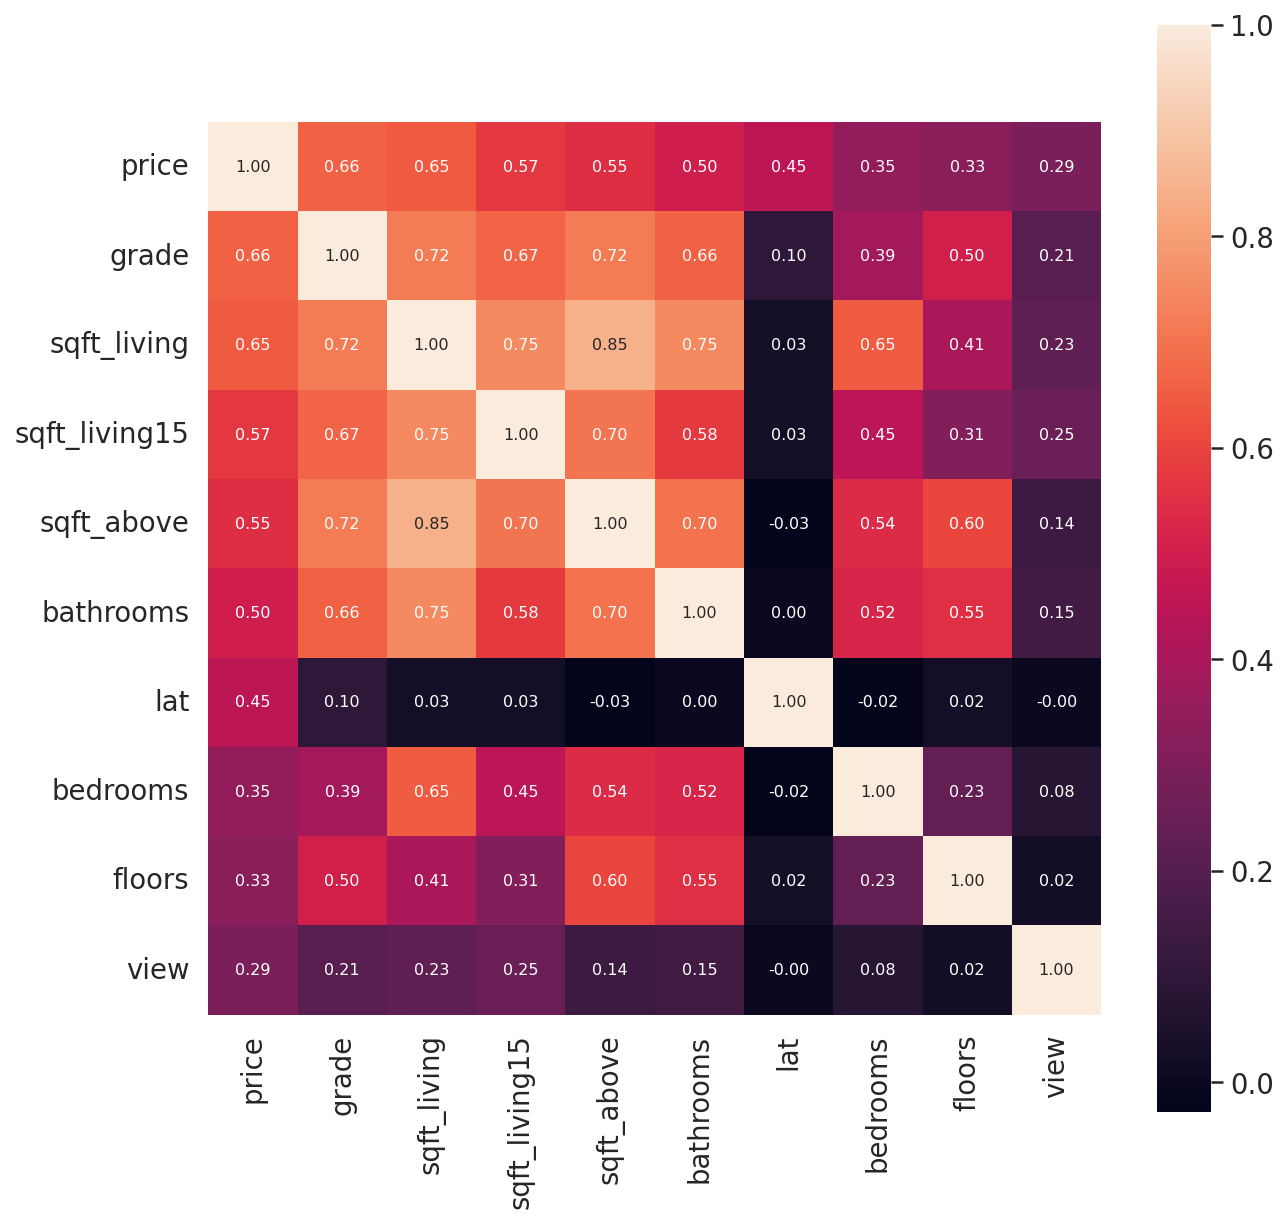

In [7]:
# 변수간 상관관계 파악
# kaggle code 참고: https://www.kaggle.com/code/vyvydkf628/house-price-prediction-eda-updated-2019-03-324eda

import scipy as sp

cor_abs = abs(train.corr(method='spearman')) 
cor_cols = cor_abs.nlargest(n=10, columns='price').index # price과 correlation이 높은 column 10개 뽑기(내림차순)
# spearman coefficient matrix
cor = np.array(sp.stats.spearmanr(train[cor_cols].values))[0] # 10 x 10
print(cor_cols.values)
plt.figure(figsize=(10,10))
sns.set(font_scale=1.25)
sns.heatmap(cor, fmt='.2f', annot=True, square=True , annot_kws={'size' : 8} ,xticklabels=cor_cols.values, yticklabels=cor_cols.values)

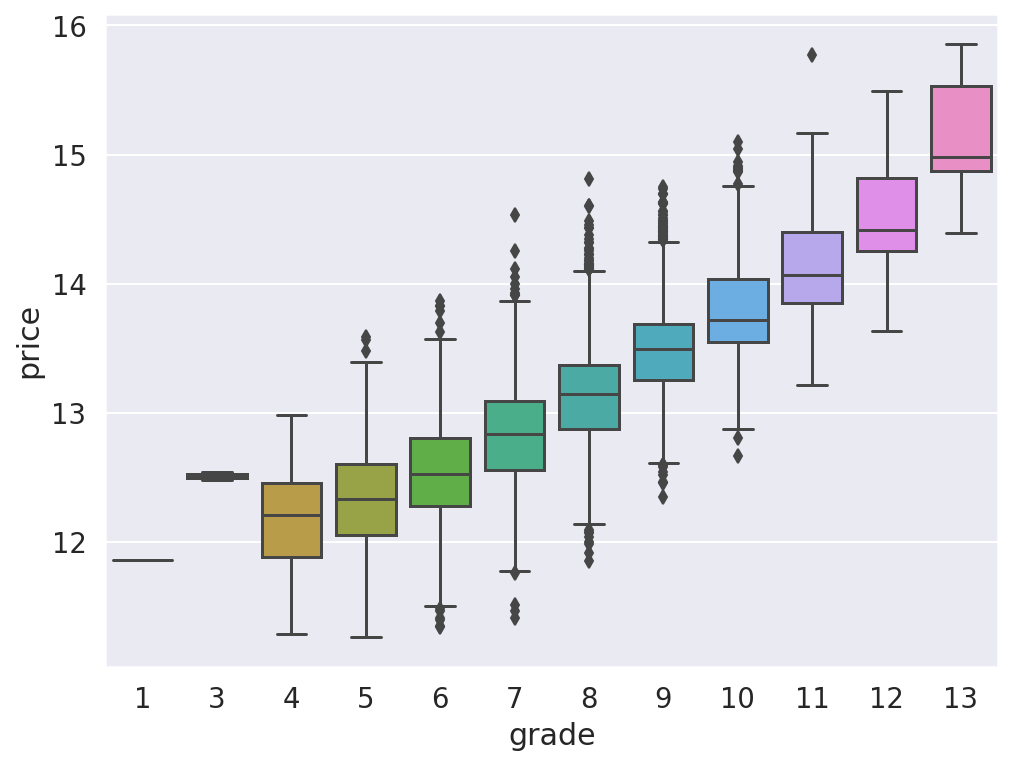

In [8]:
# Price와 가정 연관성이 큰 Grade와의 관련성 : 이상치 높은 것 제외 필요
data = pd.concat([train['price'], train['grade']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x='grade', y="price", data=data)

In [9]:
# 이상치 파악 :
train.loc[(train['price']>12) & (train['grade'] == 3)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2302,2302,201502,12.476104,1,0.75,520,12981,1.0,0,0,...,3,520,0,1920,0,98022,47.2082,-121.995,1340,12233
4123,4123,201411,12.542548,1,0.00,600,24501,1.0,0,0,...,3,600,0,1950,0,98045,47.5316,-121.749,990,22549


In [10]:
train.loc[(train['price']>14.7) & (train['grade'] == 8)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
7173,7173,201408,14.808763,5,4.0,4230,27295,2.0,1,4,...,8,3230,1000,1949,1985,98033,47.6803,-122.214,2660,27295


In [11]:
train.loc[(train['price']>15.5) & (train['grade'] == 11)]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
2775,2775,201406,15.77031,5,4.5,10040,37325,2.0,1,2,...,11,7680,2360,1940,2001,98004,47.65,-122.214,3930,25449


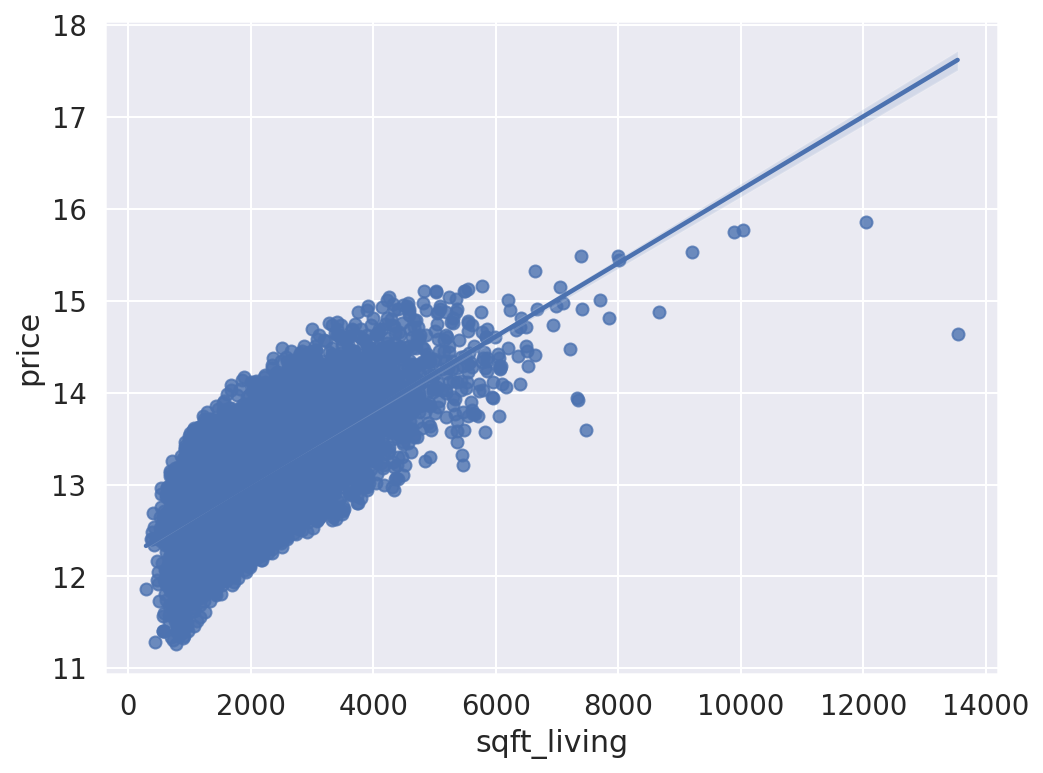

In [12]:
# 2번째 상관성이 높은 sqft_living 의 관련성: 매우 큰 이상치 발견됨
data = pd.concat([train['price'], train['sqft_living']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living', y="price", data=data)

In [13]:
# 과다 이상이 1건
train.loc[train['sqft_living'] > 13000]

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,...,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
8912,8912,201405,14.639686,7,8.0,13540,307752,3.0,0,4,...,12,9410,4130,1999,0,98053,47.6675,-121.986,4850,217800


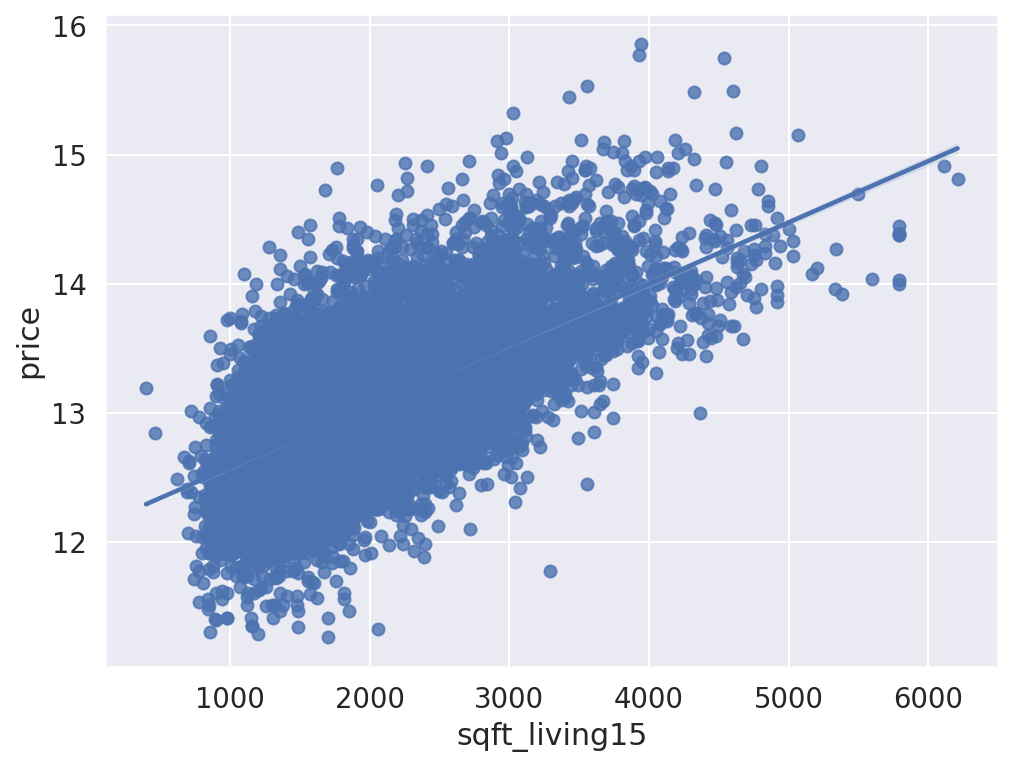

In [14]:
# 3번째 상관성이 높은 sqft_living15 의 관련성: 관련성 다소 모호함
data = pd.concat([train['price'], train['sqft_living15']], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.regplot(x='sqft_living15', y="price", data=data)

In [15]:
# 발견된 이상치 제거
train = train.loc[train['id']!=2302]
train = train.loc[train['id']!=4123]
train = train.loc[train['id']!=7173]
train = train.loc[train['id']!=2775]
train = train.loc[train['id']!=8912]

In [16]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 15030 entries, 0 to 15034
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             15030 non-null  int64  
 1   date           15030 non-null  int64  
 2   price          15030 non-null  float64
 3   bedrooms       15030 non-null  int64  
 4   bathrooms      15030 non-null  float64
 5   sqft_living    15030 non-null  int64  
 6   sqft_lot       15030 non-null  int64  
 7   floors         15030 non-null  float64
 8   waterfront     15030 non-null  int64  
 9   view           15030 non-null  int64  
 10  condition      15030 non-null  int64  
 11  grade          15030 non-null  int64  
 12  sqft_above     15030 non-null  int64  
 13  sqft_basement  15030 non-null  int64  
 14  yr_built       15030 non-null  int64  
 15  yr_renovated   15030 non-null  int64  
 16  zipcode        15030 non-null  int64  
 17  lat            15030 non-null  float64
 18  long  

In [17]:
# 정규화
# https://www.kaggle.com/kcs93023/2019-ml-month-2nd-baseline 코드활용

skew_columns = ['sqft_living', 'sqft_lot', 'sqft_above', 'sqft_basement']

for c in skew_columns:
    train[c] = np.log1p(train[c].values)
    test[c] = np.log1p(test[c].values)        

In [18]:
# 변수수정
# 추가정보 : https://www.kaggle.com/code/vyvydkf628/house-price-prediction-eda-updated-2019-03-324eda 참조
for df in [train,test]:
    df['yr_renovated'] = df['yr_renovated'].apply(lambda x: np.nan if x == 0 else x)
    df['yr_renovated'] = df['yr_renovated'].fillna(df['yr_built'])

In [19]:
# 변수생성
for df in [train,test]:
    # 방의 전체 갯수 
    df['total_rooms'] = df['bedrooms'] + df['bathrooms']
    
    # 거실의 비율 
    df['sqft_ratio'] = df['sqft_living'] / df['sqft_lot']
    
    df['sqft_total_size'] = df['sqft_above'] + df['sqft_basement']
    
    # 면적 대비 거실의 비율 
    df['sqft_ratio_1'] = df['sqft_living'] / df['sqft_total_size']
    
    df['sqft_ratio15'] = df['sqft_living15'] / df['sqft_lot15'] 
    
    # 재건축 여부 
    df['is_renovated'] = df['yr_renovated'] - df['yr_built']
    df['is_renovated'] = df['is_renovated'].apply(lambda x: 0 if x == 0 else 1)

In [21]:
# 집값의 경우 비슷한 지역의 집값 참조하기 위한 코드
train['per_price'] = train['price']/train['sqft_total_size']
zipcode_price = train.groupby(['zipcode'])['per_price'].agg({'mean','var'}).reset_index()
train = pd.merge(train,zipcode_price,how='left',on='zipcode')
test = pd.merge(test,zipcode_price,how='left',on='zipcode')

for df in [train,test]:
    df['zipcode_mean'] = df['mean'] * df['sqft_total_size']
    df['zipcode_var'] = df['var'] * df['sqft_total_size']
    del df['mean']; del df['var']

In [22]:
# Target Data 형성(price) 및 불필요한 필드 삭제
y = train['price']
del train['price']
del train['id']
del train['per_price']
print(train.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')


In [23]:
test.columns

Index(['id', 'date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot',
       'floors', 'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')

In [24]:
# Test Data 전처리
test['date'] = test['date'].apply(lambda i:i[:6]).astype(int)
del test['id']
print(test.columns)

Index(['date', 'bedrooms', 'bathrooms', 'sqft_living', 'sqft_lot', 'floors',
       'waterfront', 'view', 'condition', 'grade', 'sqft_above',
       'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode', 'lat', 'long',
       'sqft_living15', 'sqft_lot15', 'total_rooms', 'sqft_ratio',
       'sqft_total_size', 'sqft_ratio_1', 'sqft_ratio15', 'is_renovated',
       'zipcode_mean', 'zipcode_var'],
      dtype='object')


In [25]:
print(len(train))
print(len(y))

15030
15030


In [26]:
# RMSE 계산에 필요한 모듈 import
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

def rmse(y_test, y_pred):
    return np.sqrt(mean_squared_error(np.expm1(y_test), np.expm1(y_pred)))


In [27]:
# 4가지 모델 import
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor
from sklearn.ensemble import GradientBoostingRegressor, RandomForestRegressor

random_state = 2020
gboost = GradientBoostingRegressor(random_state=random_state)
xgboost = XGBRegressor(random_state=random_state)
lightgbm = LGBMRegressor(random_state=random_state)
rdforest = RandomForestRegressor(random_state=random_state)
models = [gboost, xgboost, lightgbm, rdforest]

In [28]:
# 모델의 이름 접근
gboost.__class__.__name__

'GradientBoostingRegressor'

In [29]:
# 모델별 Score 함수 구성
def get_scores(model, train, y):
    df = {}
    for model in models:
        model_name = model.__class__.__name__
        
        X_train,X_test,y_train,y_test = train_test_split(train, y, random_state=random_state, test_size=0.2)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        df[model_name] = rmse(y_test, y_pred)
        score_df = pd.DataFrame(df, index=['RMSE']).T.sort_values('RMSE', ascending=False) 
        
    return score_df

get_scores(models, train, y)

,RMSE
GradientBoostingRegressor,131616.378426
RandomForestRegressor,129188.485196
LGBMRegressor,112973.918144
XGBRegressor,111200.674057


In [35]:
# Grid 탐색
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_estimators':[50,100],
    'max_dept':[1,10]
}

model = LGBMRegressor(random_state=random_state)
grid_model = GridSearchCV(model, param_grid=param_grid, \
                         scoring='neg_mean_squared_error', \
                         cv=5, verbose=1, n_jobs=5)
grid_model.fit(train,y)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[LightGBM] [Warning] Unknown parameter: max_dept


GridSearchCV(cv=5, estimator=LGBMRegressor(random_state=2020), n_jobs=5,
             param_grid={'max_dept': [1, 10], 'n_estimators': [50, 100]},
             scoring='neg_mean_squared_error', verbose=1)

In [169]:
grid_model.cv_results_

{'mean_fit_time': array([1.08453288, 1.6508122 , 1.07878866, 1.67325091]),
 'std_fit_time': array([0.19595875, 0.18963244, 0.06799488, 0.18771015]),
 'mean_score_time': array([0.07182016, 0.11984539, 0.07077832, 0.08162723]),
 'std_score_time': array([0.01672273, 0.02700035, 0.01815106, 0.04311326]),
 'param_max_dept': masked_array(data=[1, 1, 10, 10],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'param_n_estimators': masked_array(data=[50, 100, 50, 100],
              mask=[False, False, False, False],
        fill_value='?',
             dtype=object),
 'params': [{'max_dept': 1, 'n_estimators': 50},
  {'max_dept': 1, 'n_estimators': 100},
  {'max_dept': 10, 'n_estimators': 50},
  {'max_dept': 10, 'n_estimators': 100}],
 'split0_test_score': array([-0.02876934, -0.02671349, -0.02876934, -0.02671349]),
 'split1_test_score': array([-0.03048397, -0.02803311, -0.03048397, -0.02803311]),
 'split2_test_score': array([-0.03068087, -0.

In [36]:
params = grid_model.cv_results_['params']
params

[{'max_dept': 1, 'n_estimators': 50},
 {'max_dept': 1, 'n_estimators': 100},
 {'max_dept': 10, 'n_estimators': 50},
 {'max_dept': 10, 'n_estimators': 100}]

In [37]:
score = grid_model.cv_results_['mean_test_score']
score

array([-0.02919842, -0.02705114, -0.02919842, -0.02705114])

In [38]:
results = pd.DataFrame(params)
results['score'] = score
results

,max_dept,n_estimators,score
0,1,50,-0.029198
1,1,100,-0.027051
2,10,50,-0.029198
3,10,100,-0.027051


In [39]:
results['RMSE']=np.sqrt(-1*results['score'])
results

,max_dept,n_estimators,score,RMSE
0,1,50,-0.029198,0.170875
1,1,100,-0.027051,0.164472
2,10,50,-0.029198,0.170875
3,10,100,-0.027051,0.164472


In [40]:
results = results.rename(columns={'RMSE': 'RMSLE'})
results

,max_dept,n_estimators,score,RMSLE
0,1,50,-0.029198,0.170875
1,1,100,-0.027051,0.164472
2,10,50,-0.029198,0.170875
3,10,100,-0.027051,0.164472


In [41]:
results = results.sort_values('RMSLE')
results

,max_dept,n_estimators,score,RMSLE
1,1,100,-0.027051,0.164472
3,10,100,-0.027051,0.164472
0,1,50,-0.029198,0.170875
2,10,50,-0.029198,0.170875


In [42]:
# Grid Search의 함수 구현
def my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5):
    grid_model = GridSearchCV(model, param_grid=param_grid, \
                             scoring='neg_mean_squared_error', \
                             cv=5, verbose=verbose, n_jobs=n_jobs)
    grid_model.fit(train,y)
    params = grid_model.cv_results_['params']
    score = grid_model.cv_results_['mean_test_score']
    
    results = pd.DataFrame(params)
    results['score'] = score
    
    results['RMSLE'] = np.sqrt(-1*results['score'])
    results = results.sort_values(['RMSLE'])
    
    return results

In [97]:
# LGBMRegressor Tuning
params_grid = {
    'n_estimators': [50,100],
    'max_depth': [1,10]
    }
model = LGBMRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 4 candidates, totalling 20 fits


,max_dept,n_estimators,score,RMSLE
1,1,100,-0.027051,0.164472
3,10,100,-0.027051,0.164472
0,1,50,-0.029198,0.170875
2,10,50,-0.029198,0.170875


In [112]:
# XGBRegressor Tuning
param_grid = {
"learning_rate"    : [0.10, 0.20, 0.30 ] ,
 "max_depth"        : [ 3, 5, 8, 10, 12],
    }
model = XGBRegressor(random_state=random_state)
my_GridSearch(model, train, y, param_grid, verbose=2, n_jobs=5)

Fitting 5 folds for each of 15 candidates, totalling 75 fits


,learning_rate,max_depth,score,RMSLE
2,0.1,8,-0.026850,0.163861
3,0.1,10,-0.027051,0.164472
4,0.1,12,-0.027629,0.166221
7,0.2,8,-0.027862,0.166918
6,0.2,5,-0.028011,0.167364
11,0.3,5,-0.028205,0.167945
8,0.2,10,-0.028680,0.169350
1,0.1,5,-0.029056,0.170458
9,0.2,12,-0.029148,0.170727
10,0.3,3,-0.029846,0.172759


[13:04:50] WARNING: ../src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END ........................max_dept=1, n_estimators=50; total time=  15.7s
[13:05:06] WARNING: ../src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings but
  passed down to XGBoost core.  Or some parameters are not used but slip through this
  verification. Please open an issue if you find above cases.


[CV] END .......................max_dept=1, n_estimators=100; total time= 1.0min
[13:06:08] WARNING: ../src/learner.cc:573: 
Parameters: { "max_dept" } might not be used.

  This may not be accurate due to some parameters are only used in language bindings bu

In [177]:
# 모델 파라메터 변경1
model = LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
model.fit(train,y)
prediction = model.predict(test)
prediction

array([13.13580793, 13.08051399, 14.11202067, ..., 13.01592878,
       12.69894979, 12.96297768])

In [129]:
# 모델 파라메터 변경2
model = XGBRegressor(learning_rate=0.05, random_state=random_state)
model.fit(train,y)
prediction = model.predict(test)
prediction

array([13.132664, 12.798381, 13.984782, ..., 12.911938, 12.652106,
       12.938051], dtype=float32)

In [178]:
# 로그값을 원래 스케일로 변환
prediction = np.expm1(prediction)
prediction

array([ 506766.66784595,  479506.10405112, 1345155.15609376, ...,
        449515.92243642,  327402.87855805,  426332.71354302])

In [179]:
#  튜닝한 모델의 결과값 제출
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)
submission.head()

,id,price
0,15035,100000
1,15036,100000
2,15037,100000
3,15038,100000
4,15039,100000


In [180]:
submission['price']=prediction
submission.head()

,id,price
0,15035,5.067667e+05
1,15036,4.795061e+05
2,15037,1.345155e+06
3,15038,3.122579e+05
4,15039,3.338645e+05


In [181]:
my_submission_path = join(data_dir,'submission_8th.csv')
result.to_csv(my_submission_path, index=False)
print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_8th.csv


In [102]:
# save submission 함수 구성
def save_submission(model, train, y, test, model_name, rmsle=None):
    model.fit(train,y)
    prediction = model.predict(test)
    prediction = np.expm1(prediction)
    data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
    submission_path = join(data_dir, 'sample_submission.csv')
    submission = pd.read_csv(submission_path)
    submission.to_csv(submission_csv_path, index=False)
    print('{} saved!'.format(submission_csv_path))
    
    save_submission(model, train, y, test, 'lgbm', rmsle='0.0168')

In [30]:
# Ensemble 기법 사용 : 여러 회귀모델의 평균 블렌딩 
gboost = GradientBoostingRegressor(learning_rate=0.1,random_state=random_state)
xgboost = xgb.XGBRegressor(max_depth=8,learning_rate=0.1, random_state=random_state)
lightgbm = lgb.LGBMRegressor(max_depth=10, n_estimators=100, random_state=random_state)
rf = RandomForestRegressor(random_state=random_state)
models = [{'model':gboost, 'name':'GradientBoosting'},{'model':xgboost,'name':'XGBoost'},{'model':lightgbm,'name':'LightGBM'},{'model':rf,'name':'RandomForest'}]


In [31]:
# Cross Validation : R2 점수 반환
def get_cv_score(models):
    kfold = KFold(n_splits=5).get_n_splits(train.values)
    for m in models:
        CV_score = np.mean(cross_val_score(m['model'], X=train.values, y=y, cv=kfold))
        print(f"Model: {m['name']}, CV score: {CV_score:.4f}")
 
get_cv_score(models)

Model: GradientBoosting, CV score: 0.8800
Model: XGBoost, CV score: 0.9019
Model: LightGBM, CV score: 0.9017
Model: RandomForest, CV score: 0.8841


In [32]:
# 각 모델들의 평균값 산출

def AveragingBlending(models, x, y,sub_x):
    for m in models:
        m['model'].fit(x.values, y)
        
    predictions = np.column_stack([m['model'].predict(sub_x.values) for m in models])
    return np.mean(predictions, axis=1)

y_pred = AveragingBlending(models,train,y,test)
print(len(y_pred))
y_pred

6468


array([13.14156986, 13.00999665, 14.07429407, ..., 13.00651031,
       12.70131868, 12.95941304])

In [33]:
# 로그값을 원래 스케일로 변환
y_pred = np.expm1(y_pred)
y_pred

array([ 509695.0582191 ,  446857.22512883, 1295352.35176668, ...,
        445302.03539875,  328179.38104389,  424815.69063042])

In [42]:
data_dir = os.getenv('HOME')+'/aiffel/kaggle_kakr_housing/data'
submission_path = join(data_dir, 'sample_submission.csv')
submission = pd.read_csv(submission_path)

result = pd.DataFrame({
    'id': sub_id,
    'price': y_pred
})

result.head()

,id,price
0,15035,5.096951e+05
1,15036,4.468572e+05
2,15037,1.295352e+06
3,15038,3.031440e+05
4,15039,3.214228e+05


In [43]:
my_submission_path = join(data_dir,'submission_13th.csv')
result.to_csv(my_submission_path, index=False)
print(my_submission_path)

/aiffel/aiffel/kaggle_kakr_housing/data/submission_13th.csv


## [ 회고 ]
  - 하이퍼파라메터 튜닝 기법을 적용하였으나, 디폴트 값과 크게 차이 나지는 않음. 시간이 많이 소요됨
  - 데이터의 피처를 분석하여 모델에 활용하는 것이 좀 더 도움이 되는 것 같음
  - 앙상블 기법을 사용한 예측력이 단독 모델보다 더 잘 나오는 것을 확인했고, 이에 대한 수학적인 근거가 있음을 처음 알았음
  - 캐글 Competition 에 참여하는 방법을 알게 되었으며, 좋은 Score를 얻기가 어려웠다. (고수들 많은 것 같음)